In [6]:
import collections
import multiprocessing
import threading
import random
import redis
import requests
import json
import sys
import time

import tornado.httpclient
import tornado.ioloop
import tornado.gen


rps = collections.defaultdict(list)
cpu_stats = []
lock = threading.Lock()
redis_cli = redis.StrictRedis('localhost', 63799)

SAMPLE_TIME = 5. # Seconds
RESOLUTION = 1.
ENDPOINT = 'http://api.io:8080/bounded/cpu'
loop = tornado.ioloop.IOLoop.current()
threads = []


@tornado.gen.coroutine
def main():
    print("Starting main...")
    client = tornado.httpclient.AsyncHTTPClient()
    requests_per_second = RESOLUTION
    while True:
        yield tornado.gen.sleep(1.)
        try:
            redis_cli.incr('client_requests')
            resp = yield client.fetch(ENDPOINT)
            if 200 <= resp.code < 300:
                redis_cli.incr('client_requests_succeeded')
                result = json.loads(resp.body)
                with lock:
                    cpu_stats.append(result)
            else:
                redis_cli.incr('client_requests_failed')
        except Exception as e:
            print("Caught exception", e)
            redis_cli.incr('client_requests_failed')
            

loop.call_later(0., main)


<TimerHandle when=25599.216548856 IOLoop._run_callback(functools.par... 0x1227020d0>))>

Starting main...


In [7]:
%matplotlib inline
import sys
import os.path
import json
import operator
import collections
import numpy
from scipy.stats import gaussian_kde
import scipy.linalg
import pickle
import random
import pandas
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

import matplotlib.pyplot as plt
import pickle


DO_NOT_PLOT = set([])# set(['host.process.cpu.io_wait', 'host.memory.Inactive(anon):.value', 'host.memory.Shmem:.value', 'host.memory.Writeback:.value'])
NUM_DATAPOINTS = 5000

with open('cpu-2019-2-3.pickle', 'rb') as fp:
    cpu_stats = pickle.loads(fp.read())

def flatten(nested_dict):
    for k, v in nested_dict.items():
        if not isinstance(v, dict):
            yield k, v
        else:
            for _k, _v in flatten(v):
                yield ".".join([k, _k]), _v 
                

def uninteresting(Y):
    stddev = numpy.std(Y)
    mean = numpy.mean(Y)
    if stddev < 10e-8:
        return True
    return False

    
def assert_nonnegative(label, Y):
    for value in Y:
        assert value >= 0, "Found non-negative value in {}".format(label)
    return True

                
def plot_points(title, x_label, y_label, points, heatmap=False):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    X, Y = points
    if heatmap:
        xy = numpy.vstack([X, Y])
        try:
            Z = gaussian_kde(xy)(xy)
            plt.scatter(X, Y, c=Z, s=75, edgecolor='')
            plt.colorbar()
        except scipy.linalg.LinAlgError as e:
            plt.scatter(X, Y)
    else:
        plt.plot(X, Y)
    plt.show()
    

def cast_ts_to_bin(ts, bin_size):
    return int(ts / bin_size) * bin_size
     
        
def add_stats(a, b):
    c = {'elements': a.get('elements', 0) + b.get('elements', 0) + 1}
    for k, v in a.items():
        if isinstance(v, dict):
            c[k] = add_stats(a.get(k, {}), b.get(k, {}))
        elif isinstance(v, (int, float)):
            c[k] = a.get(k, 0.) + b.get(k, 0.)
        elif not isinstance(v, (str, bytes)) and v is not None:
            print(type(v))
    return c


def bin_stats(stats, ms_bin=100):
    binned = collections.defaultdict(dict)
    for stat in stats:
        bin = cast_ts_to_bin(stat.get('t_ms'), ms_bin)
        binned[bin] = add_stats(stat, binned[bin])
        binned[bin]['t_ms'] = bin
    return sorted([b for b in binned.values()], key=lambda o: o.get('t_ms'))


def filter_overflows_from_columns(columns):
    indices_to_slice = set([])
    for label, column in columns.items():
        for i, value in enumerate(column):
            try:
                if value * value > sys.maxsize or (0 < value < 10e-9):
                    indices_to_slice.add(i)                    
            except Exception as e:
                print(e, 'label', label, 'value', value)
                break
    indices_to_slice = sorted(list(indices_to_slice), reverse=True) # hi to lo
    for label, column in columns.items():
        for index in indices_to_slice:
            column.pop(index)
    return columns, len(indices_to_slice)


def build_columns(binned_stats):
    columns = collections.defaultdict(list)
    for stat in binned_stats:
        for label, value in flatten(stat):
            if isinstance(value, (str, bytes)):
                break
            columns[label].append(value)
    return {label: column[0:NUM_DATAPOINTS] 
            for label, column in columns.items() 
            if not uninteresting(column) and label != 't_ms'}

    
variable_types = {'duration': 'c'}
columns, num_filtered = filter_overflows_from_columns(build_columns(bin_stats(cpu_stats[1:], ms_bin=1.)))
print('filtered', num_filtered, 'overflows')
for label, column in columns.items():
    if label not in variable_types:
        variable_types[label] = 'c'
for label, column in columns.items():
    if label in variable_types:
        assert_nonnegative(label, column)
        print(label, len(column))
        
dataframe = pandas.DataFrame(columns)
    
print('instantiating algorithm')
ic_algorithm = IC(RobustRegressionTest, alpha=10. / (len(columns.items()) - 2.) ** 2. )
print('executing search')
graph = ic_algorithm.search(dataframe, variable_types)
print('done')

print(len(cpu_stats))


filtered 0 overflows
client_requests.failed 5000
client_requests.sent 5000
client_requests.successful 5000
duration 5000
host.memory.Active(anon):.value 5000
host.memory.Active(file):.value 5000
host.memory.Active:.value 5000
host.memory.AnonPages:.value 5000
host.memory.Buffers:.value 5000
host.memory.Cached:.value 5000
host.memory.Committed_AS:.value 5000
host.memory.Dirty:.value 5000
host.memory.Inactive(anon):.value 5000
host.memory.Inactive(file):.value 5000
host.memory.Inactive:.value 5000
host.memory.KernelStack:.value 5000
host.memory.Mapped:.value 5000
host.memory.MemAvailable:.value 5000
host.memory.MemFree:.value 5000
host.memory.PageTables:.value 5000
host.memory.SReclaimable:.value 5000
host.memory.SUnreclaim:.value 5000
host.memory.Shmem:.value 5000
host.memory.Slab:.value 5000
host.memory.Writeback:.value 5000
host.network.enp0s3.RX-OK 5000
host.network.enp0s3.TX-OK 5000
host.network.enp0s8.RX-OK 5000
host.network.enp0s8.TX-OK 5000
host.network.lo.RX-OK 5000
host.network

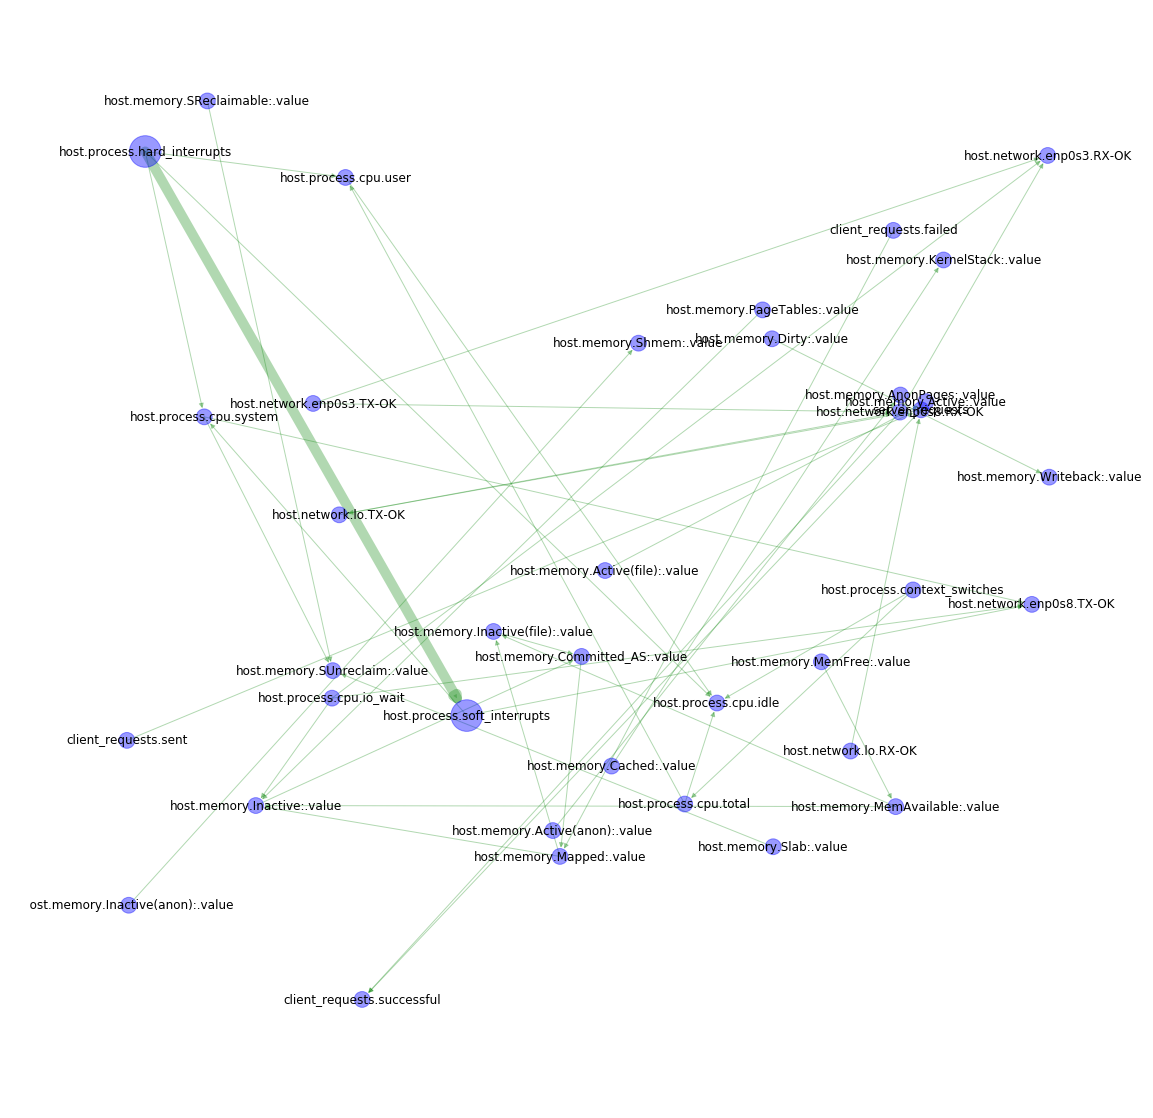

In [6]:


%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

THICK = 10.
THIN = 1.
BIG = 1000
SMALL = 250

digraph = nx.DiGraph(directed=True)
edgewidth = []
marked_nodes = set([])
for edge in graph.edges(data=True):
    u, v, edgeinfo = edge
    if u in edgeinfo.get('arrows'):
        first, second = v, u
    else:
        first, second = u, v
        
    if edgeinfo.get('marked'):
        edgeinfo['width'] = THICK
        marked_nodes.add(u)
        marked_nodes.add(v)
    else:
        edgeinfo['width'] = THIN
        
    digraph.add_edge(first, second, **edgeinfo)


pos = nx.random_layout(digraph)

plt.figure(figsize=(20, 20))
nx.draw_networkx_edges(digraph, pos, alpha=0.3, width=[e[2].get('width') for e in digraph.edges(data=True)], edge_color='g', arrows=True, arrowstyle='-|>', arrowsize=10)
nx.draw_networkx_nodes(digraph, pos, node_size=[BIG if n in marked_nodes else SMALL for n in digraph.nodes()], node_color='b', alpha=0.4)
nx.draw_networkx_labels(digraph, pos, fontsize=14)

with open('nx-cpu-2019-02-05.pickle', 'wb') as fp:
    fp.write(pickle.dumps(digraph))

plt.axis('off')
plt.show()


### Bottleneck Definition

A _bottleneck_ occurs when the capacity of an application is limited by a single component.

An application is limited when sending client requests at a higher rate does not result in requests being processed at a higher rate.

If the rate of client requests into a system is $ C_{in} $ and the rate of requests processed by that system is $ S_{out} $; then a bottleneck occurs when $ C_{in} > S_{out} \forall C_{in} > C_{critical} $ Where $ C_{critical} $ is the _critical_ rate of requests at which we reach a bottleneck.

A resource _causes_ a bottleneck when
  - there is a bottleneck
  - that resources allocation has reached its maximum allowed value

### Maximum Allocation Definition

A resource has reached _a_ maximum allocation, $ A_{max} $ when 
  - it has a known maximum quantity and its measured value is equal to that value within some episilon or
  - the (absolute value of the) rate of change of allocation with respect to incoming client requests reaches 0 from some positive value.
  
Some resources are typically measured as parts of a whole (e.g. user vs system CPU). Let $ \textbf{R} = \{R_i, R_{i+1}, ..., R{n}\} $ 
where $ n \in \mathbb{N} $ be a vector of weights of each component resource.

This type of resource is at a maximum when $ \sum_N{R_i} = 1 $.

### Observations

The variance of metrics with respect to incoming client requests gets very high when there is a bottleneck. Client requests vary randomly about that point, and so do resource allocations.

Validation process:

  - Create a network bound process
    - figure out the total bandwidth on the interface
    - find the duration of a request
    - given maximum overlap, the total throughput of the request should add to the interface bandwidth
    - request size = total bandwidth (mb/s) / bottleneck rate (rps)?
    - ensure it is not memory bound
  - Collect metrics
    - create a processes sending 1 rps/s
    - add 1 additional process every 5 minutes
    - stop at 100 processes
    - write the metrics to disk each time we add a new process
  - Save as a .pickle file (e.g. network.pickle)
  - Verify that network i/o has increasing variance
  
  - Create a CPU bound process
  - Run fibonacci sequences
  - verify the same
  
  - Create a memory bound process
  - verify the same
    
# Explanation

As we approach $ C_{critical} $ 
  - the total resources _per_ request varies increasingly
  - when we hit a maximum allocation of resources $ A_{max} $ the number of client requests can still vary while the resource allocation stays constant. When there are fewer client RPS the allocation can change to something < $ A_{max} $ 
  
 Investigate whether or not we can get CPU variance to increase while bottlenecking at another resource.